Best attempts at reproducing minimal version of an algorithm proposed at https://arxiv.org/abs/2205.14977. Original code can be found [here](https://github.com/vistalab-technion/vqr)

## Work in progress.

In [7]:
from data_utils import create_joint_x_y
from sklearn.preprocessing import StandardScaler
import numpy as np


num_points_to_generate = 1000
num_latent_points_to_generate = 1000


scaler = StandardScaler()
X, Y = create_joint_x_y(num_points_to_generate)
X_scaled = scaler.fit_transform(X)

n, d = Y.shape
U = np.random.normal(size=(num_latent_points_to_generate, d))
m = U.shape[0]

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

In [8]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
epsilon = 0.01
num_epochs = 5000

U_tensor = torch.tensor(U, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
X_tensor = torch.tensor(X_scaled, **device_and_dtype_specifications)
nu_tensor = torch.tensor(nu, **device_and_dtype_specifications)
mu_tensor = torch.tensor(mu, **device_and_dtype_specifications)

psi_tensor = torch.full(size=(Y_tensor.shape[0], 1), fill_value=0.1, requires_grad=True, **device_and_dtype_specifications)
b_tensor = torch.zeros(*(m, 1), requires_grad=True, **device_and_dtype_specifications)

optimizer = torch.optim.Adam([dict(params=[b_tensor, psi_tensor])], lr=0.1)

for epoch_idx in range(num_epochs):
        optimizer.zero_grad()

        phi_tensor = epsilon * torch.logsumexp(
                (
                        U_tensor @ Y_tensor.T  - # (m, q) @ (q, N)
                        b_tensor @ X_tensor.T - # (m, 1) @ (1, N)
                        psi_tensor.reshape(1, -1) # (N, 1).reshape(1, N)
                ) / epsilon
                , dim = 1
        ) # (m, 1)

        objective = psi_tensor.T @ nu_tensor + phi_tensor.T @ mu_tensor # (N, 1).T @ (N, 1) + (m, 1).T @ (m, 1)

        objective.backward()
        optimizer.step()

with torch.no_grad():
        phi_tensor = epsilon * torch.logsumexp(
                (
                        U_tensor @ Y_tensor.T  - # (m, q) @ (q, N)
                        b_tensor @ X_tensor.T - # (m, 1) @ (1, N)
                        psi_tensor.reshape(1, -1) # (N, 1).reshape(1, N)
                ) / epsilon
                , dim = 1
        ) # (m, 1)

phi_u = phi_tensor.detach().cpu().numpy()[:, None] # (m, 1)
b_u = b_tensor.detach().cpu().numpy() # (m, 1)

In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
potential = b_u @ X_scaled[0:1] + phi_u
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

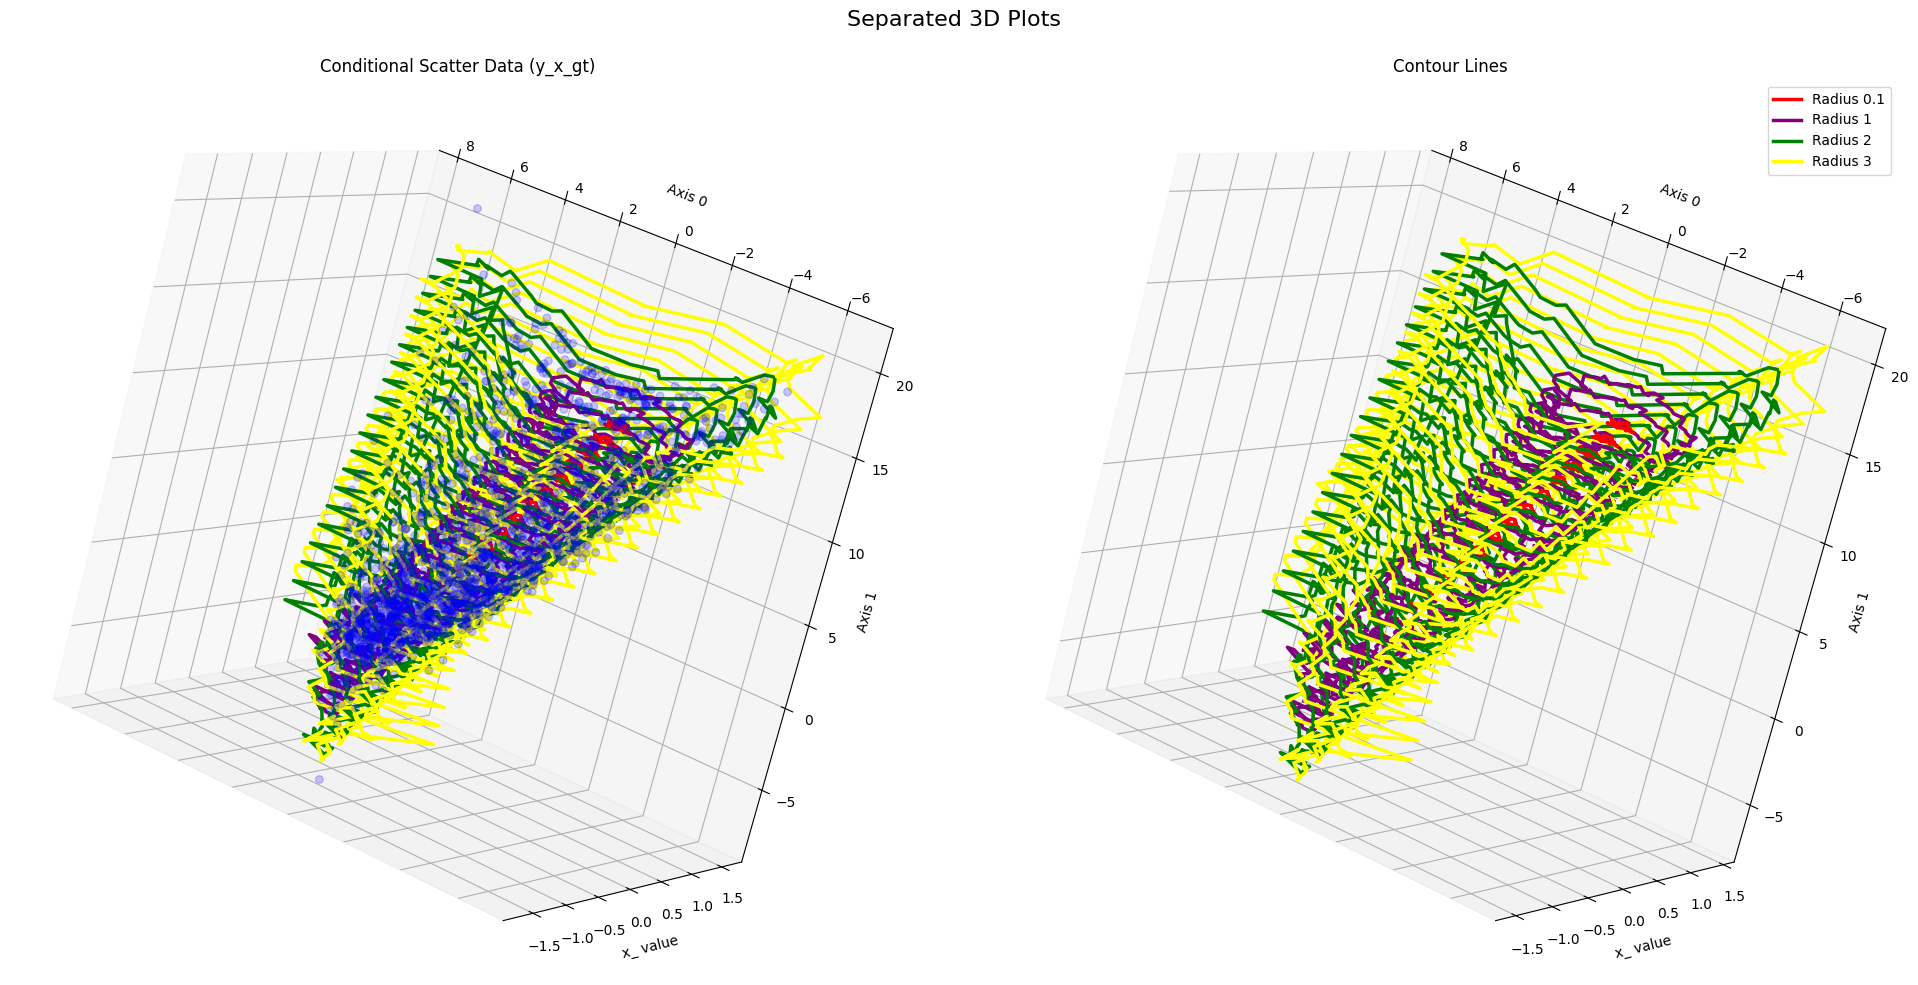

In [13]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline

from data_utils import create_conditional_x
from jaccobian_utils import estimate_gradients_for_points_knn

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), subplot_kw={'projection': '3d'})
fig.suptitle('Separated 3D Plots', fontsize=16)


ax1.set_title('Conditional Scatter Data (y_x_gt)')
ax1.set_xlabel('Axis 0')
ax1.set_ylabel('Axis 1')
ax1.set_zlabel('x_ value')

for x_ in range(50, 250, 10):
    x = scaler.transform(np.array([x_ / 100])[:, None])

    # This section is now active for the first plot
    _, y_x_gt = create_conditional_x(n_points=100, x_value=x_/100)
    z_scatter = np.full(y_x_gt.shape[0], x)
    ax1.scatter(y_x_gt[:, 0], y_x_gt[:, 1], z_scatter, color='blue', marker='o', s=30, alpha=0.2)

ax1.view_init(elev=-55, azim=154, roll=-83)

ax2.set_title('Contour Lines')
ax2.set_xlabel('Axis 0')
ax2.set_ylabel('Axis 1')
ax2.set_zlabel('x_ value')

loop_start_value = 50
for x_ in range(loop_start_value, 250, 10):
    x = scaler.transform(np.array([x_ / 100])[:, None])

    colors = ['red', 'purple', 'green', 'yellow']
    radii = [0.1, 1, 2, 3]

    for contour_radius, color in zip(radii, colors):
        pi = np.linspace(-np.pi, np.pi, 100) # Use linspace for a perfectly smooth circle

        u = np.stack([
            contour_radius * np.cos(pi),
            contour_radius * np.sin(pi),
        ])

        potential = b_u @ x + phi_u
        pushforward_of_u = estimate_gradients_for_points_knn(U, potential, points_of_interest=u.T, k=5)

        z_line = np.full(pushforward_of_u.shape[0], x)
        label = f'Radius {contour_radius}' if x_ == loop_start_value else ""
        ax1.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)
        ax2.plot(pushforward_of_u[:, 0], pushforward_of_u[:, 1], z_line, color=color, linewidth=2.5, label=label)

ax2.view_init(elev=-55, azim=154, roll=-83)
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()